In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [214]:
import torch
import os
import csv
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
#import holoviews as hv
#import bokeh
#hv.extension('bokeh')
import padasip as pa
from scipy import signal
from scipy.signal import lfilter
import math
import threading
import sys
from decimal import Decimal
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
from sklearn.metrics import mutual_info_score
from scipy.stats import multivariate_normal
#np.set_printoptions(threshold=sys.maxsize)

In [215]:
#69
seed=7568
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [216]:
#Eponymous
CONVOLUTION_SIZE=1
#RSL's mean
RSL_MU=.5
#Rate of Learning
LR=.01
#NUmber of predictors
NUM_PRED=30
#NUmber of features
NUM_FEAT=6
#SEQUENCE
SEQ=[]

In [217]:
with open('rand.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    count=0
    for row in readCSV:
        SEQ.append(int(row[1]))
len(SEQ)

1000

In [232]:
INIT=SEQ[600:]
for num in range(10):
    B=INIT[num*6:(num*6)+6]
    A=[I+1 if I!=1 else I for I in B]
    INIT=INIT+A

In [233]:
sig=np.repeat(INIT,1)
sig=np.tile(sig,5)

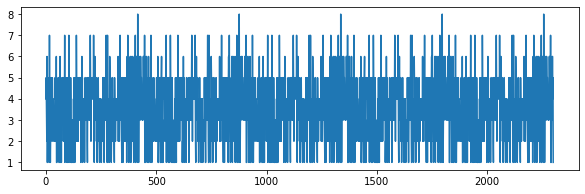

In [234]:
#A=[100]
#A=np.repeat(A,1000)
#sig=np.concatenate([A,sig])
plt.plot(sig)
size=list(range(len(sig)))

F0=10
F1=20
F2=30
F3=40
F4=50
F5=60
F6=70
F7=74
F8=80
F9=90
F10=100
F11=110
F12=120

#Filters
T0=signal.hann(F0).tolist()
T1=signal.hann(F1).tolist()
T2=signal.hann(F2).tolist()
T3=signal.hann(F3).tolist()
T4=signal.hann(F4).tolist()

T5=signal.hann(F5).tolist()
T6=signal.hann(F6).tolist()
T7=signal.hann(F7).tolist()
T8=signal.hann(F8).tolist()

T9=signal.hann(F9).tolist()
T10=signal.hann(F10).tolist()
T11=signal.hann(F11).tolist()
T12=signal.hann(F12).tolist()

#Padding with zeros
NP0=np.array([0]*(len(T0)-2)+T0)
NP1=np.array([0]*(len(T1)-2)+T1)
NP2=np.array([0]*(len(T2)-2)+T2)
NP3=np.array([0]*(len(T3)-2)+T3)
NP4=np.array([0]*(len(T4)-2)+T4)

NP5=np.array([0]*(len(T5)-2)+T5)
NP6=np.array([0]*(len(T6)-2)+T6)
NP7=np.array([0]*(len(T7)-2)+T7)
NP8=np.array([0]*(len(T8)-2)+T8)

NP9=np.array([0]*(len(T9)-2)+T9)
NP10=np.array([0]*(len(T10)-2)+T10)
NP11=np.array([0]*(len(T11)-2)+T11)
NP12=np.array([0]*(len(T12)-2)+T12)
#Features
FEATURE0=signal.convolve(sig,NP0,mode='same')/sum(NP0)
FEATURE1=signal.convolve(sig,NP1,mode='same')/sum(NP1)
FEATURE2=signal.convolve(sig,NP2,mode='same')/sum(NP2)
FEATURE3=signal.convolve(sig,NP3,mode='same')/sum(NP3)
FEATURE4=signal.convolve(sig,NP4,mode='same')/sum(NP4)

FEATURE5=signal.convolve(sig,NP5,mode='same')/sum(NP5)
FEATURE6=signal.convolve(sig,NP6,mode='same')/sum(NP6)
FEATURE7=signal.convolve(sig,NP7,mode='same')/sum(NP7)
FEATURE8=signal.convolve(sig,NP8,mode='same')/sum(NP8)

FEATURE9=signal.convolve(sig,NP9,mode='same')/sum(NP9)
FEATURE10=signal.convolve(sig,NP10,mode='same')/sum(NP10)
FEATURE11=signal.convolve(sig,NP11,mode='same')/sum(NP11)
FEATURE12=signal.convolve(sig,NP12,mode='same')/sum(NP12)
BAG=[FEATURE0,FEATURE1,FEATURE2,FEATURE3,FEATURE4,FEATURE5,FEATURE6,FEATURE7,FEATURE8,FEATURE9,FEATURE10,FEATURE11,FEATURE12]

In [235]:
def choose():
    return random.choice(BAG)

def battery_creation():
    PREDICTOR_BATTERY=[]
    for predictor_num in range(NUM_PRED):
        curr_feat=[]
        for feature in range(NUM_FEAT):
            curr_feat.append(choose())
        PREDICTOR_BATTERY.append(np.nan_to_num(np.array(curr_feat.copy()).transpose()))
    return PREDICTOR_BATTERY      

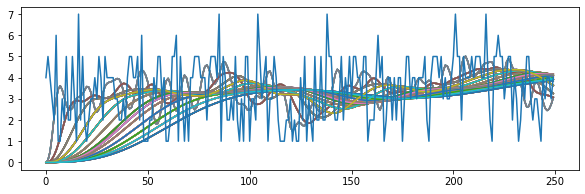

In [236]:
BATTERY=battery_creation()

#100,20,40,80
#X=np.nan_to_num(np.array([FEATURE2,FEATURE4]).transpose())
#Y=np.nan_to_num(np.array([FEATURE7,FEATURE5,FEATURE9,FEATURE2,FEATURE11,FEATURE6]).transpose())
input_size=NUM_FEAT
for pred in BATTERY:
        plt.plot(pred[0:250])
plt.plot(sig[0:250])

In [223]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, CONVOLUTION_SIZE)
        self.fc2 = nn.Linear(CONVOLUTION_SIZE, CONVOLUTION_SIZE)
        self.fc3 = nn.Linear(CONVOLUTION_SIZE, input_size)
        
    def forward(self, x):
        output = F.leaky_relu(self.fc1(x))
        output = F.leaky_relu(self.fc2(output))
        output = F.leaky_relu(self.fc3(output))
        return output

In [237]:
LOG_OUTPUT=np.zeros(BATTERY[0].shape[0])
LOG_PREDICTION=np.zeros(BATTERY[0].shape[0])

In [238]:
RSL_FILTERS=[]
for predictor in BATTERY:
    RSL_FILTERS.append(pa.filters.FilterRLS(input_size,mu=RSL_MU))
#RSL_FILTER_1=pa.filters.FilterRLS(input_size,mu=RSL_MU)
#RSL_FILTER_2=pa.filters.FilterRLS(6,mu=.1)
PREVIOUS=[]

In [226]:
model=Net()
#model_A=Net()
#model_B=Net()
optimizers =torch.optim.Adam(model.parameters(), lr=LR)
plot_loss=[]
#plot_loss_B=[]
#MI_1=[]
#MI_2=[]
#var=.2

In [239]:
for K in tqdm(range(BATTERY[0].shape[0])):
    INPUTS=[i[K] for i in BATTERY]
    
    PREDICTIONS=[]
    
    for i in range(len(INPUTS)):
        PREDICTIONS.append(RSL_FILTERS[i].predict(INPUTS[i]))
    
    pass
    
    for i in range(len(INPUTS)):
        RSL_FILTERS[i].adapt(sig[K],INPUTS[i])
    LOG_PREDICTION[K] = (1/NUM_PRED)*(float)(sum(PREDICTIONS)) 
    
    if K==0:
        for i in range(len(RSL_FILTERS)):
            PREVIOUS.append(RSL_FILTERS[i].w.copy())
        continue
    
    
    #RSL
    #########
    #MINE KL
    
    PREVIOUS_SAMPLES=np.array(PREVIOUS.copy())
    
    CURR_SAMPLES=np.array([i.w for i in RSL_FILTERS.copy()])
    
    
    PREVIOUS_TENSOR=Variable(torch.from_numpy(PREVIOUS_SAMPLES).type(torch.FloatTensor), requires_grad = True)
    
    CURRENT_TENSOR=Variable(torch.from_numpy(CURR_SAMPLES).type(torch.FloatTensor), requires_grad = True)
    
    PREV_STATE=model(PREVIOUS_TENSOR)
    
    CURR_STATE=model(CURRENT_TENSOR)
    
    
    RET=torch.mean(CURR_STATE)-torch.log(torch.mean(torch.exp(PREV_STATE)))
    

    
    LOSS=-RET
    
    
    
    plot_loss.append(LOSS.data.numpy())
    model.zero_grad()
    
    
    LOSS.backward()
    
    optimizers.step()
    PREVIOUS=[]
    for i in range(len(RSL_FILTERS)):
        PREVIOUS.append(RSL_FILTERS[i].w.copy())    

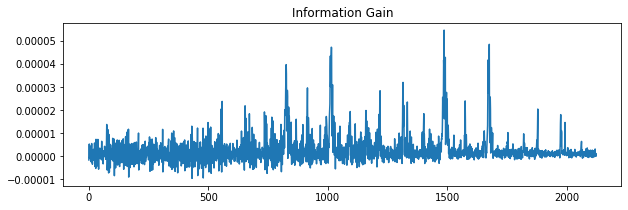

In [228]:

#plot_loss=[i*10 for i in plot_loss]
plt.rcParams["figure.figsize"] = (10,3)
plt.title('Information Gain')

plt.plot(plot_loss[1175:])
#plot_loss

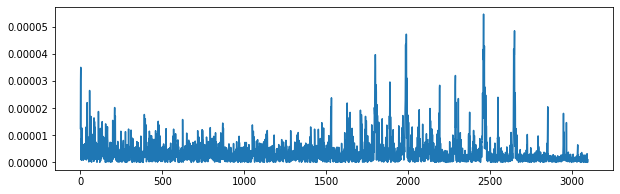

In [229]:
plot_loss=[abs(i) for i in plot_loss]

plt.plot(plot_loss[200:4000])

3300
0.00640187797463741


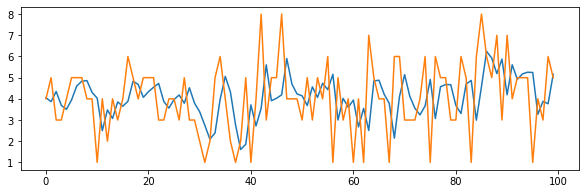

In [231]:
print(len(sig))
plt.plot(LOG_PREDICTION[3200:])
plt.plot(sig[3200:])
C=[a-b for a,b in zip(LOG_PREDICTION,sig)]
LOSS=sum(C)/len(C)
print(LOSS)
#Train data

2300
0.0039044301154841344


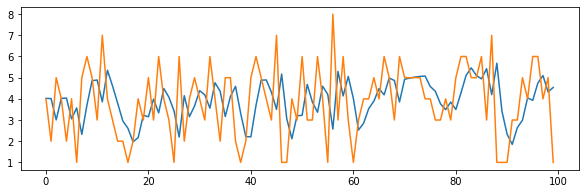

In [241]:
print(len(sig))
plt.plot(LOG_PREDICTION[2200:])
plt.plot(sig[2200:])
C=[a-b for a,b in zip(LOG_PREDICTION,sig)]
LOSS=sum(C)/len(C)
print(LOSS)
#Test data

2300
0.0039044301154841344


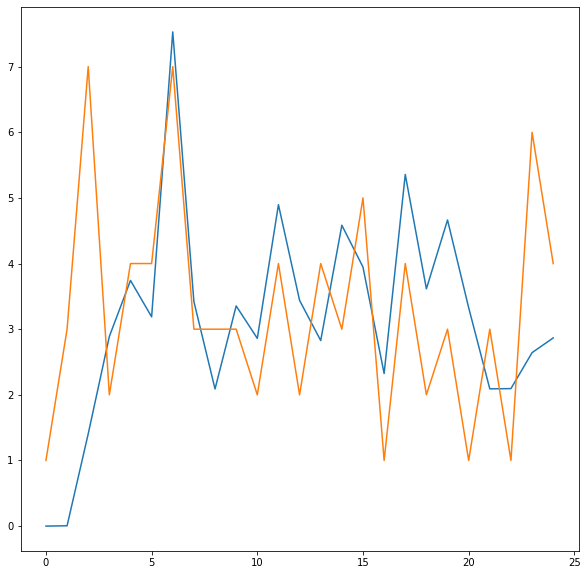

In [254]:
print(len(sig))
plt.plot(LOG_PREDICTION[:25])
plt.plot(SEQ[:25])
C=[a-b for a,b in zip(LOG_PREDICTION,sig)]
LOSS=sum(C)/len(C)
print(LOSS)
#Test data

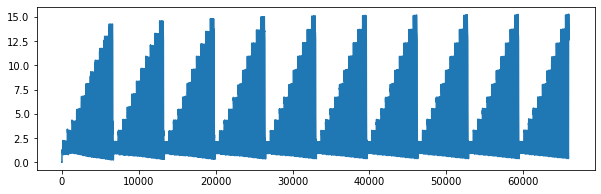

In [38]:
plt.plot(LOG_PREDICTION)

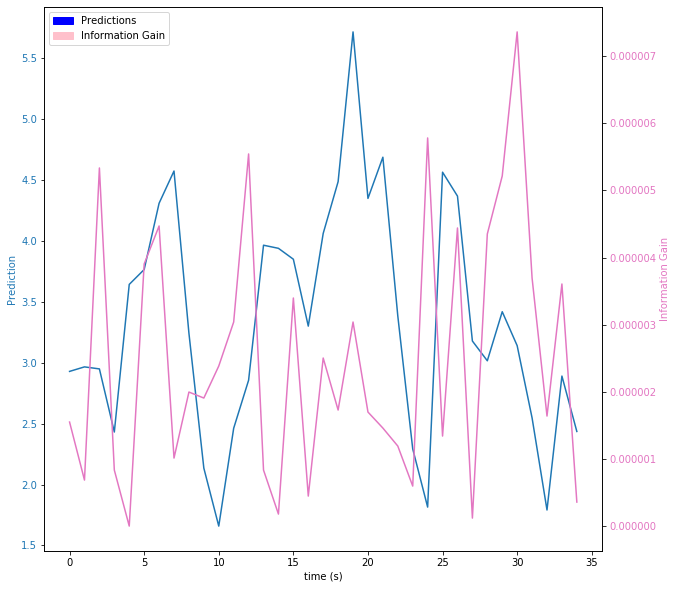

In [244]:
plt.rcParams["figure.figsize"] = (10,10)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Prediction', color=color)
ax1.plot(LOG_PREDICTION[1175:1210], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:pink'
ax2.set_ylabel('Information Gain', color=color)  # we already handled the x-label with ax1
ax2.plot(plot_loss[1175:1210], color=color)
ax2.tick_params(axis='y', labelcolor=color)

blue_patch = mpatches.Patch(color='blue', label='Predictions')
pink_patch = mpatches.Patch(color='pink', label='Information Gain')
plt.legend(handles=[blue_patch,pink_patch])


#e-error
#err=10*np.log10((LOG_PREDICTION-sig)**2)
#plt.plot(plot_loss[:])
#plt.plot(sig[:])
#plt.plot(A[:])
#plt.plot(SMOOTHED[10000:])
#plt.plot(LOG_PREDICTION[:])
#plt.plot(MI_1[2000:])


#plt.plot(MI_1[4000:4250])

In [ ]:
#there is a relation between the LR and how the plot_loss come out
#Any LR>.01 was not as good for the loss being synced up with the MI and the sig
#any LR<.01 had the same problem
#The current graph comes from LR=.01, covariance matrix of RSL_W/100=diag, 6 features, 1 predictor, and the size of samples is 400.